# Focusing Properties of a Metasurface Lens

This example demonstrates how to compute the far-field profile at the focal length of a metasurface lens. The lens design, which is also part of the tutorial, is based on a supercell of binary-grating unit cells. For a review of the binary-grating geometry as well as a demonstration of computing its phasemap, see [Tutorial/Mode Decomposition/Phase Map of a Subwavelength Binary Grating](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#phase-map-of-a-subwavelength-binary-grating). The far-field calculation of the lens contains two separate components: (1) compute the phasemap of the unit cell as a function of a single geometric parameter, the duty cycle, while keeping its height and periodicity fixed (1.8 and 0.3 μm), and (2) form the supercell lens by tuning the local phase of each of a variable number of unit cells according to the quadratic formula for planar wavefront focusing. The design wavelength is 0.5 μm and the focal length is 0.2 mm. The input source is an $E_z$-polarized planewave at normal incidence.

The key to the script is the function `grating` with three geometric input arguments (periodicity, height, and list of duty cycles) which performs the two main tasks: (1) for a unit cell, it computes the phase (as well as the transmittance) and then translates this value from the range of [-π,π] of Mode Decomposition to [-2π,0] in order to be consistent with the analytic formula for the local phase and (2) for a supercell, it computes the far-field intensity profile around the focal length of the lens.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 2.0  # substrate thickness
dpad = 2.0  # padding between grating and PML

lcen = 0.5  # center wavelength
fcen = 1 / lcen  # center frequency
df = 0.2 * fcen  # frequency width

focal_length = 200  # focal length of metalens
spot_length = 100  # far field line length
ff_res = 10  # far field resolution (points/μm)

k_point = mp.Vector3(0, 0, 0)

glass = mp.Medium(index=1.5)

pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

symmetries = [mp.Mirror(mp.Y)]


def grating(gp, gh, gdc_list):
    sx = dpml + dsub + gh + dpad + dpml
    src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
    mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad)
    geometry = [
        mp.Block(
            material=glass,
            size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
            center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
        )
    ]

    num_cells = len(gdc_list)
    if num_cells == 1:
        sy = gp
        cell_size = mp.Vector3(sx, sy)

        sources = [
            mp.Source(
                mp.GaussianSource(fcen, fwidth=df),
                component=mp.Ez,
                center=src_pt,
                size=mp.Vector3(y=sy),
            )
        ]

        sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            k_point=k_point,
            default_material=glass,
            sources=sources,
            symmetries=symmetries,
        )

        flux_obj = sim.add_flux(
            fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
        )

        sim.run(until_after_sources=50)

        input_flux = mp.get_fluxes(flux_obj)

        sim.reset_meep()

        geometry.append(
            mp.Block(
                material=glass,
                size=mp.Vector3(gh, gdc_list[0] * gp, mp.inf),
                center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh),
            )
        )

        sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            geometry=geometry,
            k_point=k_point,
            sources=sources,
            symmetries=symmetries,
        )

        flux_obj = sim.add_flux(
            fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
        )

        sim.run(until_after_sources=200)

        freqs = mp.get_eigenmode_freqs(flux_obj)
        res = sim.get_eigenmode_coefficients(
            flux_obj, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y
        )
        coeffs = res.alpha

        mode_tran = abs(coeffs[0, 0, 0]) ** 2 / input_flux[0]
        mode_phase = np.angle(coeffs[0, 0, 0])
        if mode_phase > 0:
            mode_phase -= 2 * np.pi

        return mode_tran, mode_phase

    else:
        sy = num_cells * gp
        cell_size = mp.Vector3(sx, sy)

        sources = [
            mp.Source(
                mp.GaussianSource(fcen, fwidth=df),
                component=mp.Ez,
                center=src_pt,
                size=mp.Vector3(y=sy),
            )
        ]

        for j in range(num_cells):
            geometry.append(
                mp.Block(
                    material=glass,
                    size=mp.Vector3(gh, gdc_list[j] * gp, mp.inf),
                    center=mp.Vector3(
                        -0.5 * sx + dpml + dsub + 0.5 * gh, -0.5 * sy + (j + 0.5) * gp
                    ),
                )
            )

        sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            geometry=geometry,
            k_point=k_point,
            sources=sources,
            symmetries=symmetries,
        )

        n2f_obj = sim.add_near2far(
            fcen, 0, 1, mp.Near2FarRegion(center=mon_pt, size=mp.Vector3(y=sy))
        )

        sim.run(until_after_sources=100)

        return (
            abs(
                sim.get_farfields(
                    n2f_obj,
                    ff_res,
                    center=mp.Vector3(-0.5 * sx + dpml + dsub + gh + focal_length),
                    size=mp.Vector3(spot_length),
                )["Ez"]
            )
            ** 2
        )

In the first of two parts of the calculation, a phasemap of the binary-grating unit cell is generated based on varying the duty cycle from 0.1 to 0.9.

In [2]:
gp = 0.3  # grating periodicity
gh = 1.8  # grating height
gdc = np.linspace(0.1, 0.9, 30)  # grating duty cycle

mode_tran = np.empty((gdc.size))
mode_phase = np.empty((gdc.size))
for n in range(gdc.size):
    mode_tran[n], mode_phase[n] = grating(gp, gh, [gdc[n]])

-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00247622 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
time for set_epsilon = 0.00647688 s
-----------
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00136495 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,0,0)
          size (1.8,0.03,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0103281 s
-----------
run 0 finishe

Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
time for set_epsilon = 0.00456905 s
-----------
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00162697 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,0,0)
          size (1.8,0.087931,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0103731 s
-----------
run 0 finished at t = 225.0 (22500 timesteps)
MPB solved for omega_1(2,0,0) = 2 after 8 iters
Dominant planewave for band 1: (2.000000,-0.000000,0.000000)
-----------
Initializin

Halving computational cell along direction y
time for choose_chunkdivision = 0.000782967 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,0,0)
          size (1.8,0.145862,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0097518 s
-----------
run 0 finished at t = 225.0 (22500 timesteps)
MPB solved for omega_1(2,0,0) = 2 after 7 iters
Dominant planewave for band 1: (2.000000,-0.000000,0.000000)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.000844002 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
time for set_epsilon = 

     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,0,0)
          size (1.8,0.203793,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.009727 s
-----------
run 0 finished at t = 225.0 (22500 timesteps)
MPB solved for omega_1(2,0,0) = 2 after 8 iters
Dominant planewave for band 1: (2.000000,-0.000000,0.000000)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00181007 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
time for set_epsilon = 0.00469708 s
-----------
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell

     block, center = (1.11022e-16,0,0)
          size (1.8,0.261724,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0110409 s
-----------
run 0 finished at t = 225.0 (22500 timesteps)
MPB solved for omega_1(2,0,0) = 2 after 7 iters
Dominant planewave for band 1: (2.000000,-0.000000,0.000000)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.000945091 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
time for set_epsilon = 0.00621819 s
-----------
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.000971079 s
Working in 2D dimensions.
Computational cell is 7.8 x 0.3 x 0 with resolution 50
     block, center = (

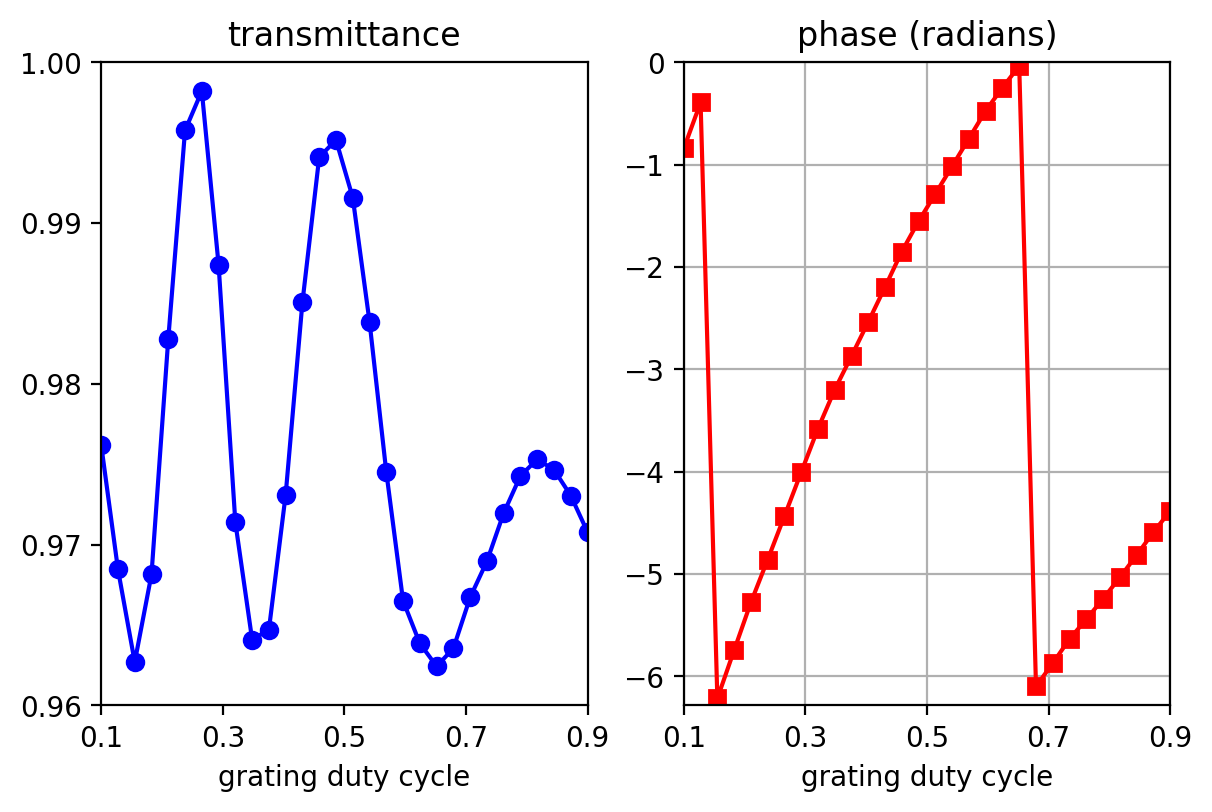

In [3]:
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.plot(gdc, mode_tran, "bo-")
plt.xlim(gdc[0], gdc[-1])
plt.xticks([t for t in np.linspace(0.1, 0.9, 5)])
plt.xlabel("grating duty cycle")
plt.ylim(0.96, 1.00)
plt.yticks([t for t in np.linspace(0.96, 1.00, 5)])
plt.title("transmittance")

plt.subplot(1, 2, 2)
plt.plot(gdc, mode_phase, "rs-")
plt.grid(True)
plt.xlim(gdc[0], gdc[-1])
plt.xticks([t for t in np.linspace(0.1, 0.9, 5)])
plt.xlabel("grating duty cycle")
plt.ylim(-2 * np.pi, 0)
plt.yticks([t for t in np.linspace(-6, 0, 7)])
plt.title("phase (radians)")

plt.tight_layout(pad=0.5)
plt.show()

The phasemap is shown above. The left figure shows the transmittance which is nearly unity for all values of the duty cycle; the Fresnel transmittance is 0.96 for the glass-air interface. This is expected since the periodicity is subwavelength. The right figure shows the phase. There is a subregion in the middle of the plot spanning the duty-cycle range of roughly 0.16 to 0.65 in which the phase varies continuously over the full range of -2π to 0. This structural regime is used to design the supercell lens.

In the second part of the calculation, the far-field energy-density profile of three supercell lens designs, comprised of 201, 401, and 801 unit cells, are computed using the quadratic formula for the local phase. Initially, this involves fitting the unit-cell phase data to a finer duty-cycle grid in order to enhance the local-phase interpolation of the supercell. This is important since as the number of unit cells in the lens increases, the local phase via the duty cycle varies more gradually from unit cell to unit cell. However, if the duty cycle becomes too gradual (i.e., less than a tenth of the pixel dimensions), the `resolution` may also need to be increased in order to improve the accuracy of [subpixel smoothing](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing).

In [4]:
gdc_new = np.linspace(0.16, 0.65, 500)
mode_phase_interp = np.interp(gdc_new, gdc, mode_phase)
print("phase-range:, {:.6f}".format(mode_phase_interp.max() - mode_phase_interp.min()))

phase_tol = 1e-2
num_cells = [100, 200, 400]
ff_nc = np.empty((spot_length * ff_res, len(num_cells)))

for k in range(len(num_cells)):
    gdc_list = []
    for j in range(-num_cells[k], num_cells[k] + 1):
        phase_local = (
            2
            * np.pi
            / lcen
            * (focal_length - ((j * gp) ** 2 + focal_length**2) ** 0.5)
        )  # local phase at the center of the j'th unit cell
        phase_mod = phase_local % (-2 * np.pi)  # restrict phase to [-2*pi,0]
        if phase_mod > mode_phase_interp.max():
            phase_mod = mode_phase_interp.max()
        if phase_mod < mode_phase_interp.min():
            phase_mod = mode_phase_interp.min()
        idx = np.transpose(
            np.nonzero(
                np.logical_and(
                    mode_phase_interp > phase_mod - phase_tol,
                    mode_phase_interp < phase_mod + phase_tol,
                )
            )
        ).ravel()
        gdc_list.append(gdc_new[idx[0]])

    ff_nc[:, k] = grating(gp, gh, gdc_list)

phase-range:, 6.086174
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.00169206 s
Working in 2D dimensions.
Computational cell is 7.8 x 60.3 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-30,0)
          size (1.8,0.109864,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-29.7,0)
          size (1.8,0.123415,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-29.4,0)
          size (1.8,0.136671,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)


get_farfields_array working on point 897 of 1000 (89% done), 0.00887155 s/point
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
time for choose_chunkdivision = 0.000861883 s
Working in 2D dimensions.
Computational cell is 7.8 x 240.3 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-120,0)
          size (1.8,0.109569,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-119.7,0)
          size (1.8,0.161122,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.11022e-16,-119.4,0)
          size (1.8,0.0609619,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
   

Shown below is the supercell lens design involving 201 unit cells. Note that even though periodic boundaries are used in the supercell calculation (via the `k_point`), the choice of cell boundaries in the *y* (or longitudinal) direction is *irrelevant* given the finite length of the lens. For example, PMLs could also have been used (at the expense of a larger cell). Although [`add_near2far`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#near-to-far-field-spectra) does support periodic boundaries (via the `nperiods` parameter), it is not necessary for this particular example.

![](https://meep.readthedocs.io/en/latest/images/metasurface_lens_epsilon.png)

The far-field energy-density profile is shown below for the three lens designs. As the number of unit cells increases, the focal spot becomes sharper and sharper. This is expected since the longer the focal length, the bigger the lens required to demonstrate focusing (which means more unit cells). In this example, the largest lens design contains 801 unit cells which corresponds to 0.24 mm or 1.2X the focal length.

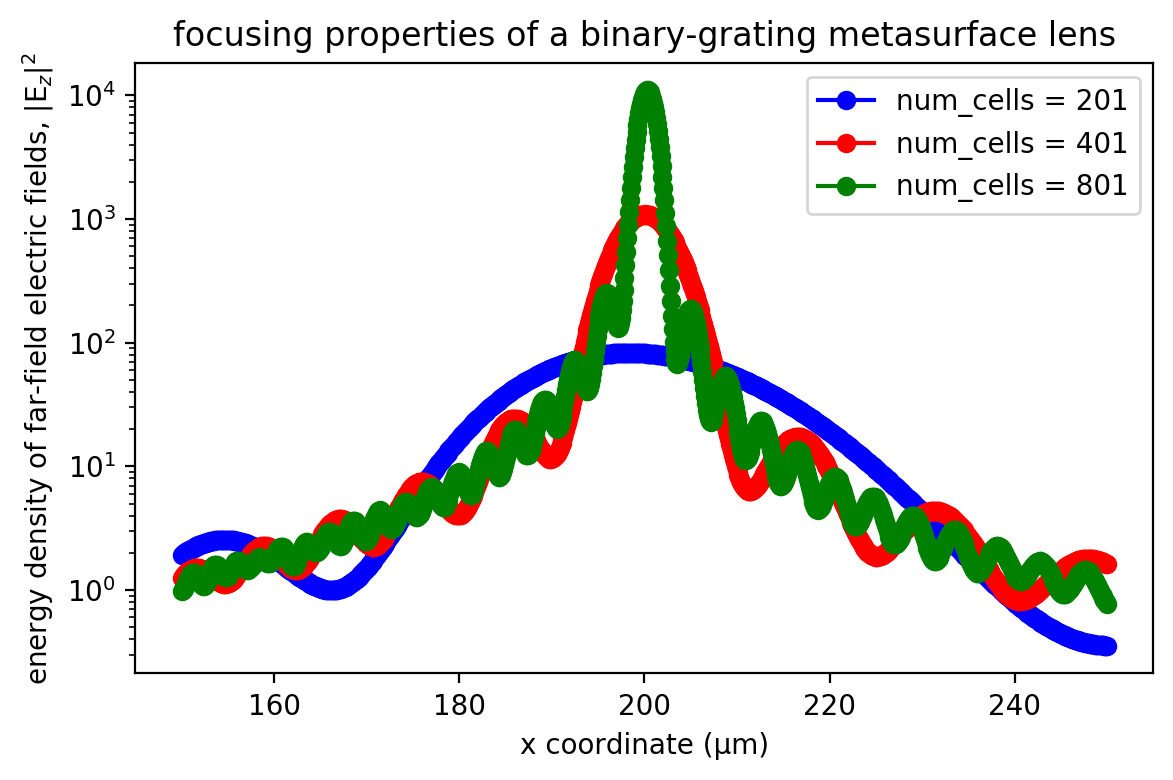

In [5]:
x = np.linspace(
    focal_length - 0.5 * spot_length,
    focal_length + 0.5 * spot_length,
    ff_res * spot_length,
)
plt.figure(dpi=200)
plt.semilogy(
    x, abs(ff_nc[:, 0]) ** 2, "bo-", label="num_cells = {}".format(2 * num_cells[0] + 1)
)
plt.semilogy(
    x, abs(ff_nc[:, 1]) ** 2, "ro-", label="num_cells = {}".format(2 * num_cells[1] + 1)
)
plt.semilogy(
    x, abs(ff_nc[:, 2]) ** 2, "go-", label="num_cells = {}".format(2 * num_cells[2] + 1)
)
plt.xlabel("x coordinate (μm)")
plt.ylabel(r"energy density of far-field electric fields, |E$_z$|$^2$")
plt.title("focusing properties of a binary-grating metasurface lens")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()